# Part 7.3 - Document Similarity on Topic Modeling
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.stats import entropy
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

2019-01-31 19:28:48
[('spark.driver.port', '43349'),
 ('spark.app.name', 'local'),
 ('spark.driver.maxResultSize', '8g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '192.168.1.207'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1548916140879'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6')]


<SparkContext master=local[*] appName=local>

**You read an article in the corpus, what if you want to know more about similar articles? In this part, we will calculate the similarity based on topic modeling and recommand similar articles for you.**

## 1 Load Data

**Meta Dataset:**

In [2]:
df_meta = load_dataset('meta', spark)
df_meta = df_meta.toPandas()
df_meta.head()

,id,publisher,region,date,ads
0,1854213,Albertland Gazette,Auckland,1862-06-14,False
1,1854215,Albertland Gazette,Auckland,1862-06-14,True
2,1854221,Albertland Gazette,Auckland,1862-06-14,False
3,1854224,Albertland Gazette,Auckland,1862-07-03,False
4,1854232,Albertland Gazette,Auckland,1863-08-01,True


**Topic List:**

In [3]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
69,69,0.00373,witness evidence accused told asked prisoner time gave house case man called stated put court deposed left made mone...
70,70,0.00828,hospital medical health disease cases patients treatment case plague patient fever doctor epidemic hospitals doctors...
151,151,0.00690,wheat oats flour market potatoes ton prices barley produce bran bushel prime good butter sacks milling feed lod baco...
150,150,0.00695,death deceased found body inquest died dead man verdict suicide morning returned evidence jury years named coroner h...
183,183,0.00855,police man found murder shot arrested men named made house night revolver constable morning crime left fired committ...


**Load doc-topic matrix:**

In [4]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id').drop('id').toPandas()

In [5]:
print('Shape of dataframe:', df_doctopic.shape)
df_doctopic.head()

Shape of dataframe: (3025602, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000048,0.000271,0.000035,0.000267,0.000526,0.000271,0.000108,0.000097,0.000119,0.000099,0.000183,0.000308,0.000089,0.000245,0.000174,0.000220,0.000105,0.000195,0.000162,0.000106,0.000062,0.000201,0.000177,0.000266,0.000162,0.000402,0.000059,0.000231,0.000406,0.000184,0.000119,0.000165,0.000226,0.000305,0.000190,0.000285,0.000245,0.000212,0.001180,0.000047,0.000163,0.000130,0.836856,0.000117,0.000070,0.000226,0.000114,0.000292,0.000209,0.000221,0.000259,0.000103,0.000459,0.000179,0.000226,0.000375,0.000306,0.000181,0.000297,0.000189,...,0.000173,0.000134,0.000209,0.000201,0.000163,0.000160,0.060030,0.000203,0.000249,0.000088,0.000208,0.000206,0.000230,0.000187,0.000215,0.000275,0.000181,0.000051,0.000193,0.000235,0.000063,0.000152,0.000180,0.000470,0.000122,0.000221,0.000175,0.000179,0.059977,0.000246,0.000145,0.000224,0.000209,0.000364,0.000098,0.000281,0.000189,0.000103,0.000156,0.000195,0.000116,0.000242,0.000158,0.000255,0.000205,0.000294,0.000117,0.000226,0.000207,0.000260,0.000085,0.000171,0.000413,0.000192,0.000238,0.000102,0.000266,0.000159,0.000215,0.000231
1,0.000028,0.000155,0.000020,0.000153,0.000301,0.000155,0.000062,0.000056,0.000068,0.000057,0.000105,0.000176,0.000051,0.000140,0.000100,0.000126,0.000060,0.000112,0.000093,0.000060,0.000036,0.000115,0.000101,0.000152,0.000093,0.000230,0.000034,0.000132,0.000233,0.000105,0.000068,0.000094,0.000129,0.000174,0.000109,0.000163,0.000140,0.000121,0.000676,0.000027,0.000093,0.000075,0.000310,0.000067,0.000040,0.239527,0.000065,0.000167,0.000120,0.000127,0.000148,0.000059,0.000263,0.000103,0.000129,0.000215,0.290872,0.000104,0.000170,0.000108,...,0.000099,0.000077,0.000120,0.000115,0.000093,0.000092,0.000168,0.000116,0.000142,0.000051,0.000119,0.000118,0.000131,0.000107,0.000123,0.000157,0.000103,0.000029,0.000111,0.000135,0.000036,0.000087,0.000103,0.000269,0.000070,0.000127,0.000100,0.000103,0.000137,0.000141,0.000083,0.000129,0.000120,0.034408,0.000056,0.000161,0.000108,0.000059,0.000089,0.000112,0.000066,0.000138,0.000091,0.000146,0.000117,0.000168,0.000067,0.000129,0.000119,0.000149,0.000049,0.359194,0.000237,0.000110,0.000136,0.000059,0.000152,0.000091,0.000123,0.000132
2,0.000039,0.000219,0.000028,0.000215,0.000424,0.000219,0.000087,0.000078,0.000096,0.000080,0.000148,0.000249,0.000072,0.000198,0.000140,0.000178,0.000085,0.000158,0.000130,0.000085,0.000050,0.000162,0.000143,0.000214,0.000131,0.000324,0.000047,0.000186,0.000328,0.000148,0.000096,0.000133,0.000182,0.000246,0.000154,0.000230,0.000198,0.000171,0.000952,0.000038,0.000132,0.000105,0.000437,0.000094,0.000056,0.000182,0.000092,0.000236,0.000169,0.000179,0.000209,0.000083,0.000370,0.000145,0.000182,0.000303,0.000247,0.000146,0.048456,0.000153,...,0.000140,0.000108,0.000169,0.000162,0.000132,0.000130,0.000237,0.000164,0.000201,0.000071,0.000168,0.000166,0.000185,0.000151,0.000173,0.000222,0.000146,0.000041,0.000156,0.000190,0.000051,0.000123,0.000145,0.000379,0.000099,0.000178,0.000141,0.000145,0.000194,0.000199,0.000117,0.000181,0.000169,0.000294,0.000079,0.000227,0.000152,0.000083,0.000126,0.000158,0.000093,0.000195,0.000128,0.000206,0.000165,0.000237,0.000094,0.000182,0.000167,0.000210,0.000069,0.000138,0.000334,0.868039,0.000192,0.000083,0.000214,0.000128,0.000174,0.000186
3,0.000036,0.000204,0.000026,0.000201,0.000396,0.000204,0.000081,0.000073,0.000089,0.000075,0.000138,0.000232,0.000067,0.000185,0.000131,0.000166,0.000079,0.000147,0.000122,0.000079,0.000047,0.000151,0.000133,0.000200,0.000122,0.000302,0.000044,0.000174,0.000306,0.000138,0.000089,0.000124,0.000170,0.000229,0.000143,0.000214,0

## 2 Test Corpus

**We could select an article or multiple atricles from the dataset we are using, or even any text from any where, as our test corpus. For instance, we will use below articale as test corpus:**

>**[Home New Zealand at War First World War Home front First World War homecomings](https://nzhistory.govt.nz/war/first-world-war-homecomings)**
>
>First World War homecomings
>  
>A soldier's story of battle
>New Zealand troops began returning from overseas in small numbers in late 1914. The first arrivals, from Samoa, were followed by many more from Egypt and Turkey, and later from England and France. Most were sick or wounded, but some were sent back because of misconduct. More troops returned home from early 1918, in line with the NZEF's scheme for demobilisation. Most were 'low category men' such as those deemed permanently unfit, who were sent home to free up hospital beds for the heavy casualties that were anticipated. Some fit men who had served for several years were sent home on furlough (leave of absence).
>
>[Image: When the Boys Come Home music]  
>'When the Boys Come Home'
>
>By the time of the armistice with Germany in November 1918, more than 24,000 men had returned home. But more than 56,000 remained overseas or were at sea. The Defence Department arranged the return of the vast majority of these troops during 1919. It also transported thousands more people: the wives and children of soldiers, civilian war workers, and New Zealanders who had served in the British army or navy.
>
>...

**Save the article in** `.tsv` **file to infer topic model by MALLET.**

In [6]:
with open('../temp/test_corpus.txt') as file:  
    text = file.read() 

df = pd.DataFrame(data={'id':[0], 'title':['First game of rugby played in NZ'], 'content':[text]})
df = df[['id', 'title', 'content']]
df.head()

,id,title,content
0,0,First game of rugby played in NZ,Home New Zealand at War First World War Home front First World War homecomings \n\nFirst World War homecomings\n \n...


In [7]:
path = r'../data/dataset/similarity/corpus.tsv'
df.to_csv(path, sep='\t', header=False, index=False, encoding='utf-8')

**Then we will use this small corpus to find similar articles in the papers past dataset.**

## 3 Infer Topic Model

**We use MALLET to infer the corpus:**

In [8]:
%%bash

bash ../5-modeling/model.sh -i '../data/dataset/similarity/corpus.tsv' -o  '../models/similarity' -p 'infer'

InputFile=../data/dataset/similarity/corpus.tsv
OutputDir=../models/similarity
Process=infer
TrainDir=../models/train
Inferencer=../models/train/inferencer.model
CORES=12
SEED1=1
SEED2=1
TOPICS=200
ITERATION=2000
ITERATIONINFER=1000
INTERVAL=40
BURNIN=300
IDFMIN=0
IDFMAX=8
19:36:34 :: Start import dataset...
Import file already exist, nothing to do.
19:36:34 :: Imported.
Pruned model already exist, nothing to do.
19:36:34 :: Pruned.
19:36:34 :: Start infering dataset...
19:36:48 :: Inferred.


In [9]:
path = r'../models/similarity/docTopicsInfer.txt'

df_doctopic_test = (load_doctopic(path, topics_shape[0], spark)).drop('index').drop('id')
df_doctopic_test = df_doctopic_test.toPandas()

print('Shape of dataset:', df_doctopic_test.shape)
df_doctopic_test.head()

Shape of dataset: (1, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000016,0.010452,0.000319,0.000091,0.000589,0.0004,0.000037,0.000033,0.00004,0.000034,0.01514,0.00031,0.000543,0.000801,0.001085,0.00028,0.000446,0.000989,0.00344,0.000036,0.000431,0.000068,0.004676,0.006757,0.000158,0.000752,0.00002,0.000078,0.01778,0.042013,0.000451,0.000159,0.001923,0.019079,0.000372,0.036919,0.001212,0.001098,0.154767,0.000016,0.000261,0.000044,0.016185,0.000245,0.000024,0.001,0.001372,0.000099,0.000071,0.000178,0.000191,0.000445,0.000361,0.000779,0.005615,0.000128,0.101134,0.000369,0.000101,0.000167,...,0.000059,0.004661,0.000276,0.000171,0.000055,0.001901,0.002356,0.000069,0.00029,0.001261,0.000276,0.00007,0.003873,0.000063,0.000996,0.000299,0.000061,0.000017,0.000168,0.005926,0.000021,0.006001,0.000061,0.000775,0.000042,0.00028,0.009804,0.02437,0.000389,0.002238,0.000152,0.000076,0.000071,0.000842,0.092448,0.000301,0.000064,0.000035,0.000053,0.004579,0.069479,0.000082,0.001079,0.000189,0.000275,0.00051,0.00086,0.00541,0.000173,0.001935,0.032543,0.000058,0.006397,0.004066,0.001927,0.000035,0.001937,0.000464,0.000176,0.000591


**List the highest weight 10 topics:**

In [10]:
df_plt = df_doctopic_test.T
df_plt.columns = ['weight']
df_plt = df_plt.reset_index(drop=True)
df_plt[['topic', 'keywords']] = df_topics[['topic_', 'keywords_']]
df_plt.sort_values(by='weight', ascending=False).head()

,weight,topic,keywords
38,0.154767,38,tin ill oil day lit zealand mil ton tie hat aro fur aid ail end tins man hut time win
136,0.120004,136,life man men great world work people good human time mind nature things years knowledge subject character make fact ...
56,0.101134,56,captain vessel boat ship sea steamer crew water board wreck men boats ashore island time passengers deck port shore ...
174,0.092448,174,ploughs machines harrows machine plough implements agents made horse binder patent iron double steel agricultural ma...
180,0.069479,180,london sold powder medicines wholesale medical public oil sauce agents genuine chemist prepared chemists medicine bo...


**Plot Weight:**

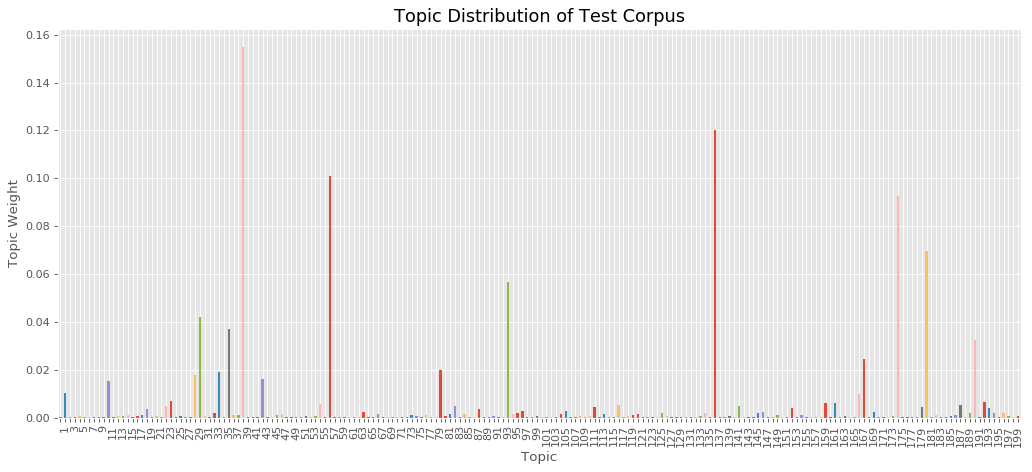

In [11]:
# plot
fig, axes = plt.subplots(figsize=(13, 6), dpi=dpi)
df_plt.plot(ax=axes, 
            kind='bar', 
            x='topic', 
            y='weight', 
            legend=False)
axes.set_title('Topic Distribution of Test Corpus', fontdict=dict(size=16))
axes.set_ylabel('Topic Weight')
axes.set_xlabel('Topic')
for label in axes.get_xticklabels()[::2]:
    label.set_visible(False)
fig.tight_layout()
plt.xticks(rotation='90')
plt.show()

## 4 Jensen-Shannon Divergence 

In [13]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query.T.values
    q = matrix.T.values
    m = 0.5*(p + q)
    return (0.5*(entropy(p,m) + entropy(q,m)))

In [14]:
def get_similar(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    #print(sims)
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [15]:
list_sim = get_similar(df_doctopic_test,df_doctopic)

print('The most similar 5 documents row index:',list_sim)

The most similar 5 documents row index: [1193904  523631  908090  355218 2741533]


## 5 Recommendation

**Based on the Jensen-Shannon Divergence, we calculated similarity list, and use the list to recommend similar documents.**

**Print meta information:**

In [16]:
#df_similar = df_clean[df_clean.index.isin(most_sim_list)]
df_similar = df_meta[df_meta.index.isin(list_sim)]
df_similar.head()

,id,publisher,region,date,ads
355218,4734903,NZ Truth,National,1916-11-11,False
523631,6264754,Bruce Herald,Otago,1897-04-23,False
908090,10120419,North Otago Times,Otago,1889-06-07,False
1193904,13023650,Southland Times,Otago,1903-12-22,True
2741533,28253248,Auckland Star,Auckland,1892-01-23,False


**Recommendation 1:**

In [17]:
# linux line number is based on 0
line = list_sim[0] +1 

In [18]:
%%bash -s $line
echo "print the $1 line:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 1193905 line:
13023650	Page 2 Advertisements Column 6	"b'POINTS FOR PURCHASEHS. JuS e ToTSd tlmt th \\xc2\\xb0 \" Just fts e\\xc2\\xb0\\xc2\\xb0\\xc2\\xab\" iIt is not a question of price, luit a &? \\xc2\\xb0! P, 1111 \"^ that keeps l> 10 MeIhe McCormick is a. certainly, in O r|K\\'i to bo certain that your crops will ScCoffikT* Weli \\' \\xc2\\xb0\\xc2\\xb0 curtftiu yoU Ket tbo'"


**Recommendation 2:**

In [19]:
# linux line number is based on 0
line = list_sim[1] +1 

In [20]:
%%bash -s $line
echo "print the $1 line:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 523632 line:
6264754	Mexima of Life.	"Mexima of Life.Hero fire win-- uiaxipj:* of life -which, if nnly s<>ni<> avo lived up to, will help In m.'iko ibo wheels of Tifo run more : -K< j *?p gtiocl company or noiii\\ Never \"be Idle. Cultivate your mhid. Make few promises. IP any\" oue speaks ill of you, let your lifn ?)e so that no one •vri!l believo ir. Never borrow. 1f you ™n possibly avoid it Live up to your eiiffupotupats. Keep your owu secrets."


**Recommendation 3:**

In [21]:
# linux line number is based on 0
line = list_sim[2] +1 

In [22]:
%%bash -s $line
echo "print the $1 line:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 908091 line:
10120419	MISCELLANEOUS.	"MISCELLANEOUS.Tht new Russian ironoUd whfoh h«i neen coramtnotd At Nioot*itffwUl be onlied tht Tw*1t» Apostles. It will b* 8076 toni duplac«m«at, and b* protected by * btlt of trootur of 14io, •nd will h» provided with engine* taYtloping upw»rd« of 8500 i h p. Th« Hsogu^ »&otbtr vowel for the KunUn n«vy, of 6950 to»i, h*u jmi >oen laid down at th« AdmlrnH; «oikv, St. Patenburg. This vtsse) <vill hare ooly p»rt'*l armour. Mrs Tftibot, of W«»hinglOD, bat l«5i> V( ry Bucoewful in Uacbiog the stiest Ar*o8 tho uie of took. Although roUl ing «g*in«t the routine of ichool life, ho< oao be taught to work nod ioou ueo mo eclf-uupportiog. She ii aided iu imparting iuutructiua by tbf ilowaid Uuivertitj.\"Thk Doctor is Always in tub Hopmi.\" — Thte it «n old aaymg, aa often repeated m Greater Britain m in ch*Moth«r Ciuntry. Happily, like many other apuoriama, it has v doublt aignitiofttioo, traoeabU to an iareatiou of Mr Richard Freaman, the welt*now

**Recommendation 4:**

In [23]:
# linux line number is based on 0
line = list_sim[3] +1 

In [24]:
%%bash -s $line
echo "print the $1 line:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 355219 line:
4734903	Untitled	"MMriatr&to: \"Why did yoo BtrUco thl« nuui?\" Priaonen \"What woold you d« If yon leapt ft- grooery atore and a man came In aad aaked If he oould bay» at raorlaff pfettcrs of your eh^eaoT\""


In [25]:
# linux line number is based on 0
line = list_sim[4] +1 

In [26]:
%%bash -s $line
echo "print the $1 line:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 2741534 line:
28253248	Untitled	"' ' ''run iorih. from _om! li. frou; K. .stand \\>*t'St ! . .\\ ih.'ia'- '•\"\"if are -i.-.i.rl'i. I ll.'tV.uJrrt'l li d ~. . iIC !. •• i-i!!', , Ui Aiaolie, .:..n bo im.vi.i. ..'.;.v.i j"


**We see the results seem make no sense. The process should be fine, the reason is that the doc-topic matrix of the test corpus is not reasonable, but the issue of calculate doc-topic matrix need to research in the future.**

---

In [27]:
sc.stop()
gc.collect()

21